In [ ]:
import numpy as np
import random
import tensorflow as tf

# Environment settings
GRID_SIZE = (6, 6)
OBSTACLES = [(0, 1), (0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (2, 4), (4, 3), (4, 4)]
START = (5, 3)
GOAL = (3, 5)
ACTIONS = ['UP', 'DOWN', 'LEFT', 'RIGHT']
NUM_ACTIONS = len(ACTIONS)
NUM_STATES = GRID_SIZE[0] * GRID_SIZE[1]

def print_initial_gridworld():
    for row in range(GRID_SIZE[0]):
        for col in range(GRID_SIZE[1]):
            if (row, col) in OBSTACLES:
                print("X", end=" ")
            elif (row, col) == START:
                print("S", end=" ")
            elif (row, col) == GOAL:
                print("G", end=" ")
            else:
                print(".", end=" ")
        print()

print_initial_gridworld()

# Hyperparameters
LEARNING_RATE_ACTOR = 0.01
LEARNING_RATE_CRITIC = 0.02
DISCOUNT_FACTOR = 0.9
EPSILON = 0.1
EPISODES = 100
CHECKPOINT_INTERVAL = 2  # Save weights every 10 episodes

# Actor and Critic Networks
actor = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(NUM_STATES,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_ACTIONS, activation='softmax')
])

critic = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(NUM_STATES,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

actor_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_ACTOR)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_CRITIC)

# Helper functions
def state_to_index(state):
    return state[0] * GRID_SIZE[1] + state[1]

def choose_action(state):
    if random.uniform(0, 1) < EPSILON:
        return random.choice(ACTIONS)
    else:
        state_flat = np.zeros(NUM_STATES)
        state_flat[state_to_index(state)] = 1
        state_tensor = tf.convert_to_tensor([state_flat], dtype=tf.float32)
        action_probs = actor(state_tensor)
        action_index = tf.random.categorical(tf.math.log(action_probs + 1e-8), 1).numpy()[0][0]
        return ACTIONS[action_index]

def step(state, action):
    action_mapping = {'UP': (-1, 0), 'DOWN': (1, 0), 'LEFT': (0, -1), 'RIGHT': (0, 1)}
    next_state = (state[0] + action_mapping[action][0], state[1] + action_mapping[action][1])
    if next_state[0] < 0 or next_state[0] >= GRID_SIZE[0] or \
       next_state[1] < 0 or next_state[1] >= GRID_SIZE[1] or \
       next_state in OBSTACLES:
        next_state = state
    reward = 1 if next_state == GOAL else -1
    done = next_state == GOAL
    return next_state, reward, done

# Initialize weight trajectory lists for actor and critic networks
actor_layer_weights = [[] for _ in range(len(actor.layers))]
critic_layer_weights = [[] for _ in range(len(critic.layers))]



. X X . . . 
. X . . . . 
. X . . X . 
. X . . . G 
. X . X X . 
. . . S . . 


In [ ]:
# Training loop
wins = 0
mse_list = []
sse_list = []
time_steps_list = []
win_rate_list = []

for episode in range(EPISODES):
    state = START
    done = False
    mse_episode = 0.0
    sse_episode = 0.0
    time_steps = 0

    while not done:
        #print(episode)
        action = choose_action(state)
        next_state, reward, done = step(state, action)

        state_flat = np.zeros(NUM_STATES)
        next_state_flat = np.zeros(NUM_STATES)
        state_flat[state_to_index(state)] = 1
        next_state_flat[state_to_index(next_state)] = 1

        state_tensor = tf.convert_to_tensor([state_flat], dtype=tf.float32)
        next_state_tensor = tf.convert_to_tensor([next_state_flat], dtype=tf.float32)

        with tf.GradientTape() as tape_critic:
            value = critic(state_tensor)
            next_value = critic(next_state_tensor)
            td_target = tf.constant(reward, dtype=tf.float32) + DISCOUNT_FACTOR * next_value * (1 - int(done))
            td_error = td_target - value
            critic_loss = tf.square(td_error)
            critic_loss = tf.reduce_mean(critic_loss)
        grads_critic = tape_critic.gradient(critic_loss, critic.trainable_variables)
        critic_optimizer.apply_gradients(zip(grads_critic, critic.trainable_variables))

        with tf.GradientTape() as tape_actor:
            action_probs = actor(state_tensor)
            action_index = ACTIONS.index(action)
            actor_loss = -tf.math.log(action_probs[0, action_index] + 1e-8) * td_error
            actor_loss = tf.reduce_mean(actor_loss)
        grads_actor = tape_actor.gradient(actor_loss, actor.trainable_variables)
        actor_optimizer.apply_gradients(zip(grads_actor, actor.trainable_variables))

        mse_episode += tf.reduce_mean(tf.square(td_error))
        sse_episode += tf.reduce_sum(tf.square(td_error))
        if done and reward == 1:
            wins += 1
        if time_steps>=250:
            wins=0
            break
        state = next_state
        time_steps += 1

    time_steps_list.append(time_steps)
    mse_list.append(mse_episode.numpy() / (time_steps))
    sse_list.append(sse_episode.numpy())
    win_rate_list.append(wins / (episode + 1))

    # Collect weights at checkpoint intervals
    if episode % CHECKPOINT_INTERVAL == 0 or episode == EPISODES - 1:
        for i, layer in enumerate(actor.layers):
            actor_layer_weights[i].append(layer.get_weights()[0])
        for i, layer in enumerate(critic.layers):
            critic_layer_weights[i].append(layer.get_weights()[0])

        print(f"Episode {episode}/{EPISODES} - MSE: {mse_list[-1]}, SSE: {sse_list[-1]}, Win Rate: {win_rate_list[-1]}")
        actor.save_weights(f'actor_weights_{episode}.h5')
        critic.save_weights(f'critic_weights_{episode}.h5')

win_rate = wins / EPISODES
print(f"Final Win Rate: {win_rate}, Final MSE: {mse_list[-1]}, Final SSE: {sse_list[-1]}")

Episode 0/100 - MSE: 0.22191744995117188, SSE: 55.47936248779297, Win Rate: 0.0
Episode 2/100 - MSE: 0.22853688049316406, SSE: 57.134220123291016, Win Rate: 0.0
Episode 4/100 - MSE: 0.9106405608508051, SSE: 89.2427749633789, Win Rate: 0.4
Episode 6/100 - MSE: 0.8166931470235189, SSE: 19.600635528564453, Win Rate: 0.5714285714285714
Episode 8/100 - MSE: 0.05718501663208008, SSE: 14.29625415802002, Win Rate: 0.0
Episode 10/100 - MSE: 0.026131608963012695, SSE: 6.532902240753174, Win Rate: 0.0
Episode 12/100 - MSE: 0.3593365311119627, SSE: 85.16275787353516, Win Rate: 0.07692307692307693
Episode 14/100 - MSE: 1.4803140813654119, SSE: 81.41727447509766, Win Rate: 0.06666666666666667
Episode 16/100 - MSE: 0.12015352630615235, SSE: 30.038381576538086, Win Rate: 0.0
Episode 18/100 - MSE: 0.3531241946750217, SSE: 22.246824264526367, Win Rate: 0.10526315789473684
Episode 20/100 - MSE: 0.18476118360246932, SSE: 31.039878845214844, Win Rate: 0.19047619047619047
Episode 22/100 - MSE: 8.90996360778

In [ ]:
# Save the model weights
actor.save_weights('final_actor_weights.h5')
critic.save_weights('final_critic_weights.h5')
print("Model weights saved.")


Model weights saved.


Mean Square Error per Episode: [0.22191744995117188, 20.563729604085285, 0.22853688049316406, 1.414940189670872, 0.9106405608508051, 0.7559163532559834, 0.8166931470235189, 0.2755992431640625, 0.05718501663208008, 0.059663619995117184, 0.026131608963012695, 0.006642500400543213, 0.3593365311119627, 0.2136488800048828, 1.4803140813654119, 0.5375670489142923, 0.12015352630615235, 0.3616037368774414, 0.3531241946750217, 0.30239517624313766, 0.18476118360246932, 0.17517074706062438, 8.909963607788086, 3.381929636001587, 0.7406255177089146, 0.7004864811897278, 0.5085006554921468, 0.9495205879211426, 0.7216644287109375, 0.9446196989579634, 0.30560165643692017, 0.3376343011856079, 0.10161244124174118, 0.09639155864715576, 0.19567511081695557, 0.023533077910542488, 0.01186739094555378, 0.012391133233904839, 0.008814129047095776, 0.0045310817658901215, 0.0035744167398661375, 0.0026481621898710728, 0.0009871843503788114, 0.0003247976419515908, 0.00046993265277706087, 0.5924357175827026, 0.186141

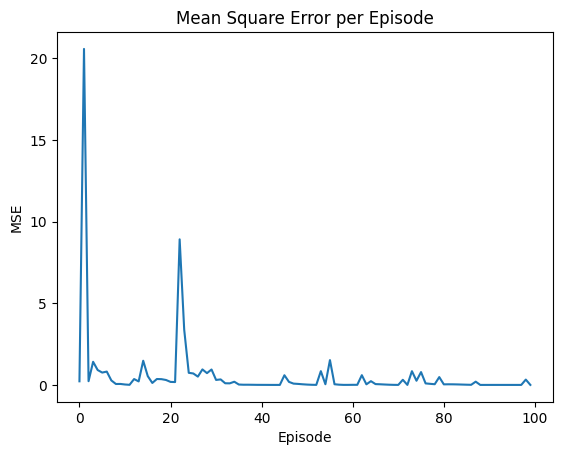

In [ ]:
import matplotlib.pyplot as plt
# Output MSE array
print("Mean Square Error per Episode:", mse_list)

# Plot MSE
plt.plot(mse_list)
plt.title("Mean Square Error per Episode")
plt.xlabel("Episode")
plt.ylabel("MSE")
plt.show()


Square Error [55.479362, 123.38238, 57.13422, 104.705574, 89.242775, 47.62273, 19.600636, 68.89981, 14.296254, 14.915905, 6.5329022, 1.6606251, 85.16276, 53.41222, 81.417274, 45.6932, 30.038382, 47.731693, 22.246824, 22.377243, 31.039879, 22.071514, 35.639854, 13.527719, 5.1843786, 2.801946, 3.051004, 5.6971235, 2.8866577, 10.390817, 1.2224066, 1.6881715, 0.40644976, 0.38556623, 0.97837555, 0.09413231, 0.047469564, 0.049564533, 0.035256516, 0.018124327, 0.014297667, 0.010592649, 0.0039487374, 0.0012991906, 0.0018797306, 3.5546143, 0.93070555, 0.31937194, 0.24707474, 0.15620857, 0.08273898, 0.032821357, 0.010229114, 11.7969265, 0.16827086, 9.119421, 0.16420439, 0.05821151, 0.010172583, 0.0122439815, 0.025031818, 0.026257806, 3.579424, 0.1491686, 1.1481836, 0.20308101, 0.15775503, 0.10049604, 0.049802314, 0.017514542, 0.005461292, 1.88371, 0.0036228993, 32.778164, 1.024656, 4.713244, 0.37057084, 0.2678318, 0.17351155, 2.8785648, 0.13924865, 0.15524575, 0.14721698, 0.1218025, 0.08809051, 

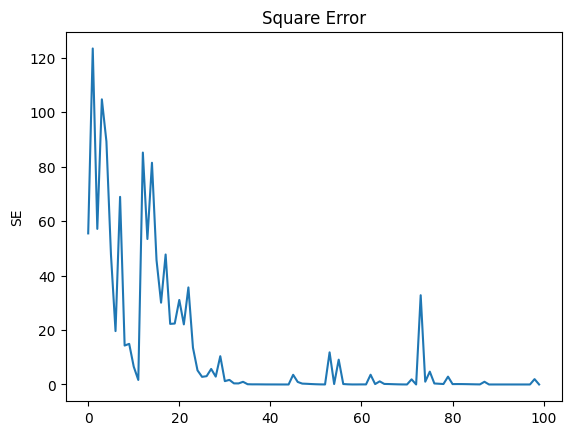

In [ ]:
import matplotlib.pyplot as plt
# Output MSE array
print("Square Error", sse_list)

# Plot MSE
plt.plot(sse_list)
plt.title("Square Error")
plt.ylabel("SE")
plt.show()


Win Rate per Episode: [0.0, 0.5, 0.0, 0.25, 0.4, 0.5, 0.5714285714285714, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07692307692307693, 0.0, 0.06666666666666667, 0.125, 0.0, 0.05555555555555555, 0.10526315789473684, 0.15, 0.19047619047619047, 0.22727272727272727, 0.2608695652173913, 0.2916666666666667, 0.32, 0.34615384615384615, 0.37037037037037035, 0.39285714285714285, 0.41379310344827586, 0.43333333333333335, 0.45161290322580644, 0.46875, 0.48484848484848486, 0.5, 0.5142857142857142, 0.5277777777777778, 0.5405405405405406, 0.5526315789473685, 0.5641025641025641, 0.575, 0.5853658536585366, 0.5952380952380952, 0.6046511627906976, 0.6136363636363636, 0.6222222222222222, 0.6304347826086957, 0.6382978723404256, 0.6458333333333334, 0.6530612244897959, 0.66, 0.6666666666666666, 0.6730769230769231, 0.6792452830188679, 0.6851851851851852, 0.6909090909090909, 0.6964285714285714, 0.7017543859649122, 0.7068965517241379, 0.711864406779661, 0.7166666666666667, 0.7213114754098361, 0.7258064516129032, 0.73015873015

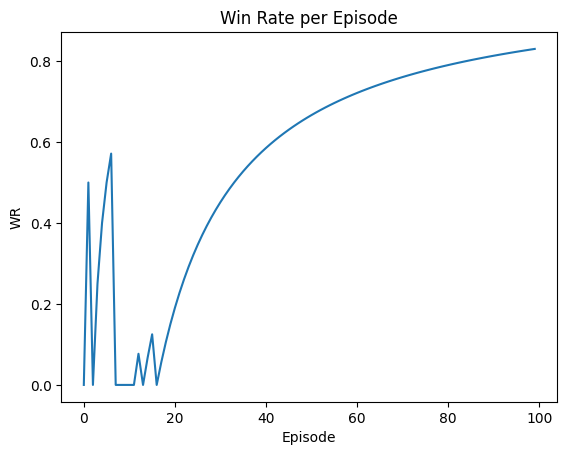

In [ ]:
import matplotlib.pyplot as plt
print("Win Rate per Episode:", win_rate_list)

plt.plot(win_rate_list)
plt.title("Win Rate per Episode")
plt.xlabel("Episode")
plt.ylabel("WR")
plt.show()


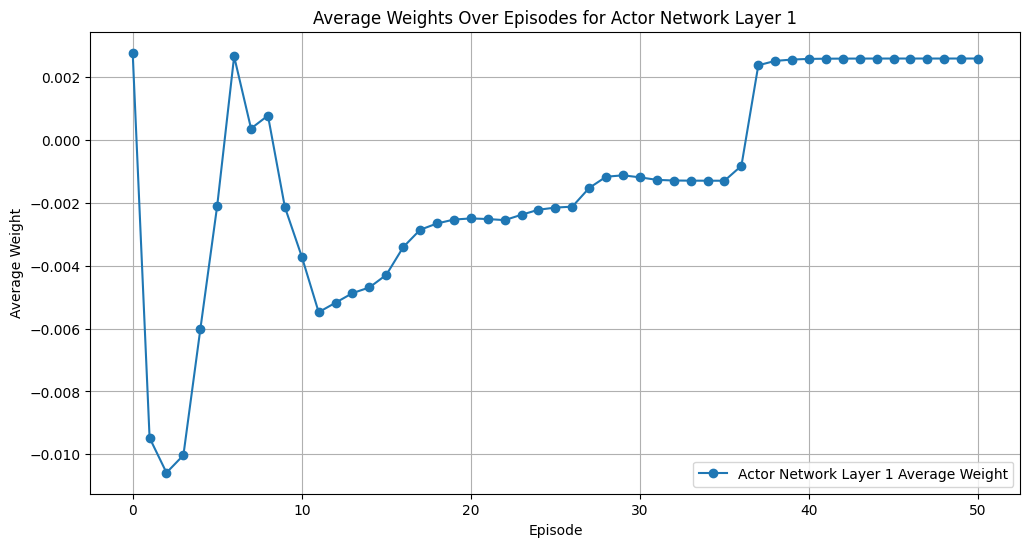

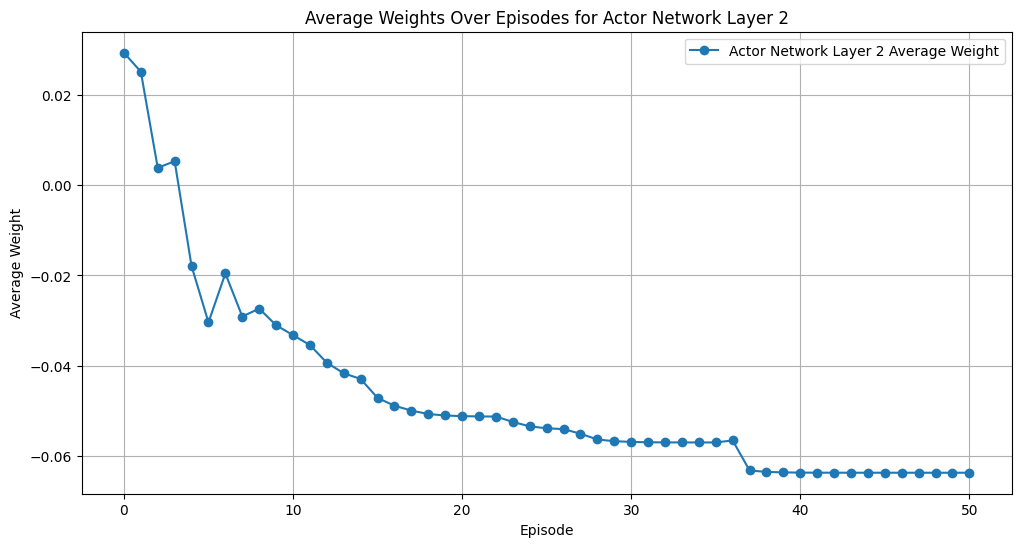

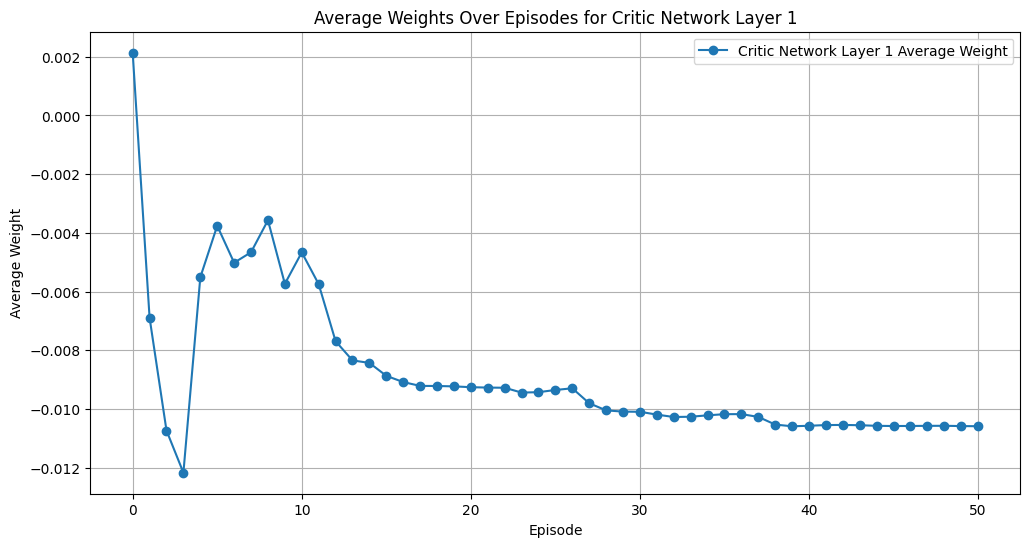

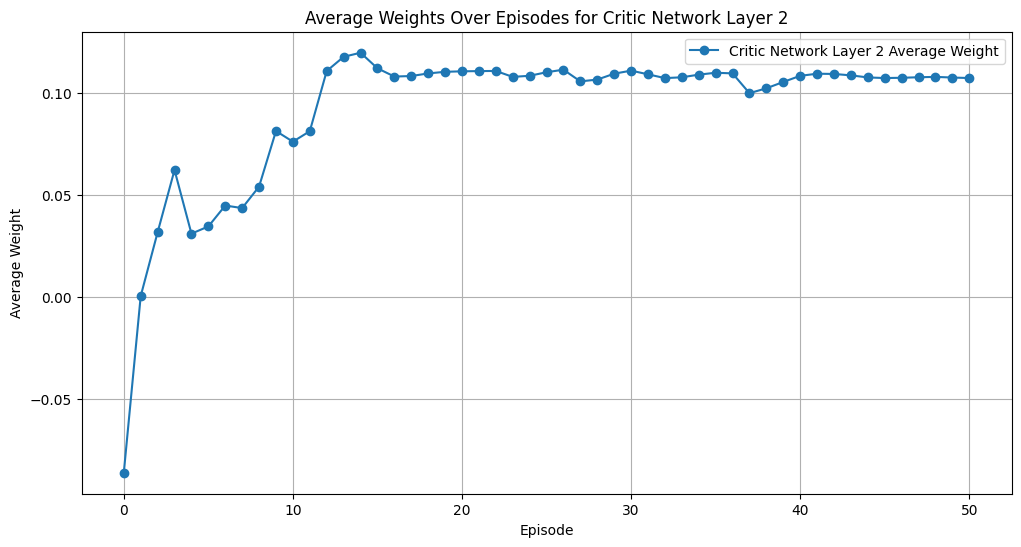

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the average weights of a neural network layer over episodes.
def plot_layer_weights_over_episodes(layer_weights, layer_name):
    # Calculate the average weight for each set of weights in the layer_weights list.
    # This assumes layer_weights is a list of arrays, where each array contains
    # the weights for a single episode.
    average_weights = [np.mean(weights) for weights in layer_weights]

    # Create a figure for the plot with a specified size.
    plt.figure(figsize=(12, 6))

    # Plot the calculated average weights across episodes.
    # Each point represents the average weight for a layer at a specific episode.
    plt.plot(average_weights, marker='o', linestyle='-', label=f'{layer_name} Average Weight')

    # Title the plot and label the axes.
    plt.title(f'Average Weights Over Episodes for {layer_name}')
    plt.xlabel('Episode')
    plt.ylabel('Average Weight')

    # Add a legend to the plot to identify the data series.
    plt.legend()

    # Enable the grid for better readability of the plot.
    plt.grid(True)

    # Display the plot.
    plt.show()

# Assuming actor_layer_weights and critic_layer_weights are lists of lists,
# where each inner list contains arrays of weights for each episode for one layer.
# The outer list corresponds to different layers.

# For each layer in the actor network, use the function to plot
# the average weights over all episodes.
for i, layer in enumerate(actor_layer_weights):
    plot_layer_weights_over_episodes(layer, f'Actor Network Layer {i+1}')

# Repeat the plotting for each layer in the critic network.
for i, layer in enumerate(critic_layer_weights):
    plot_layer_weights_over_episodes(layer, f'Critic Network Layer {i+1}')


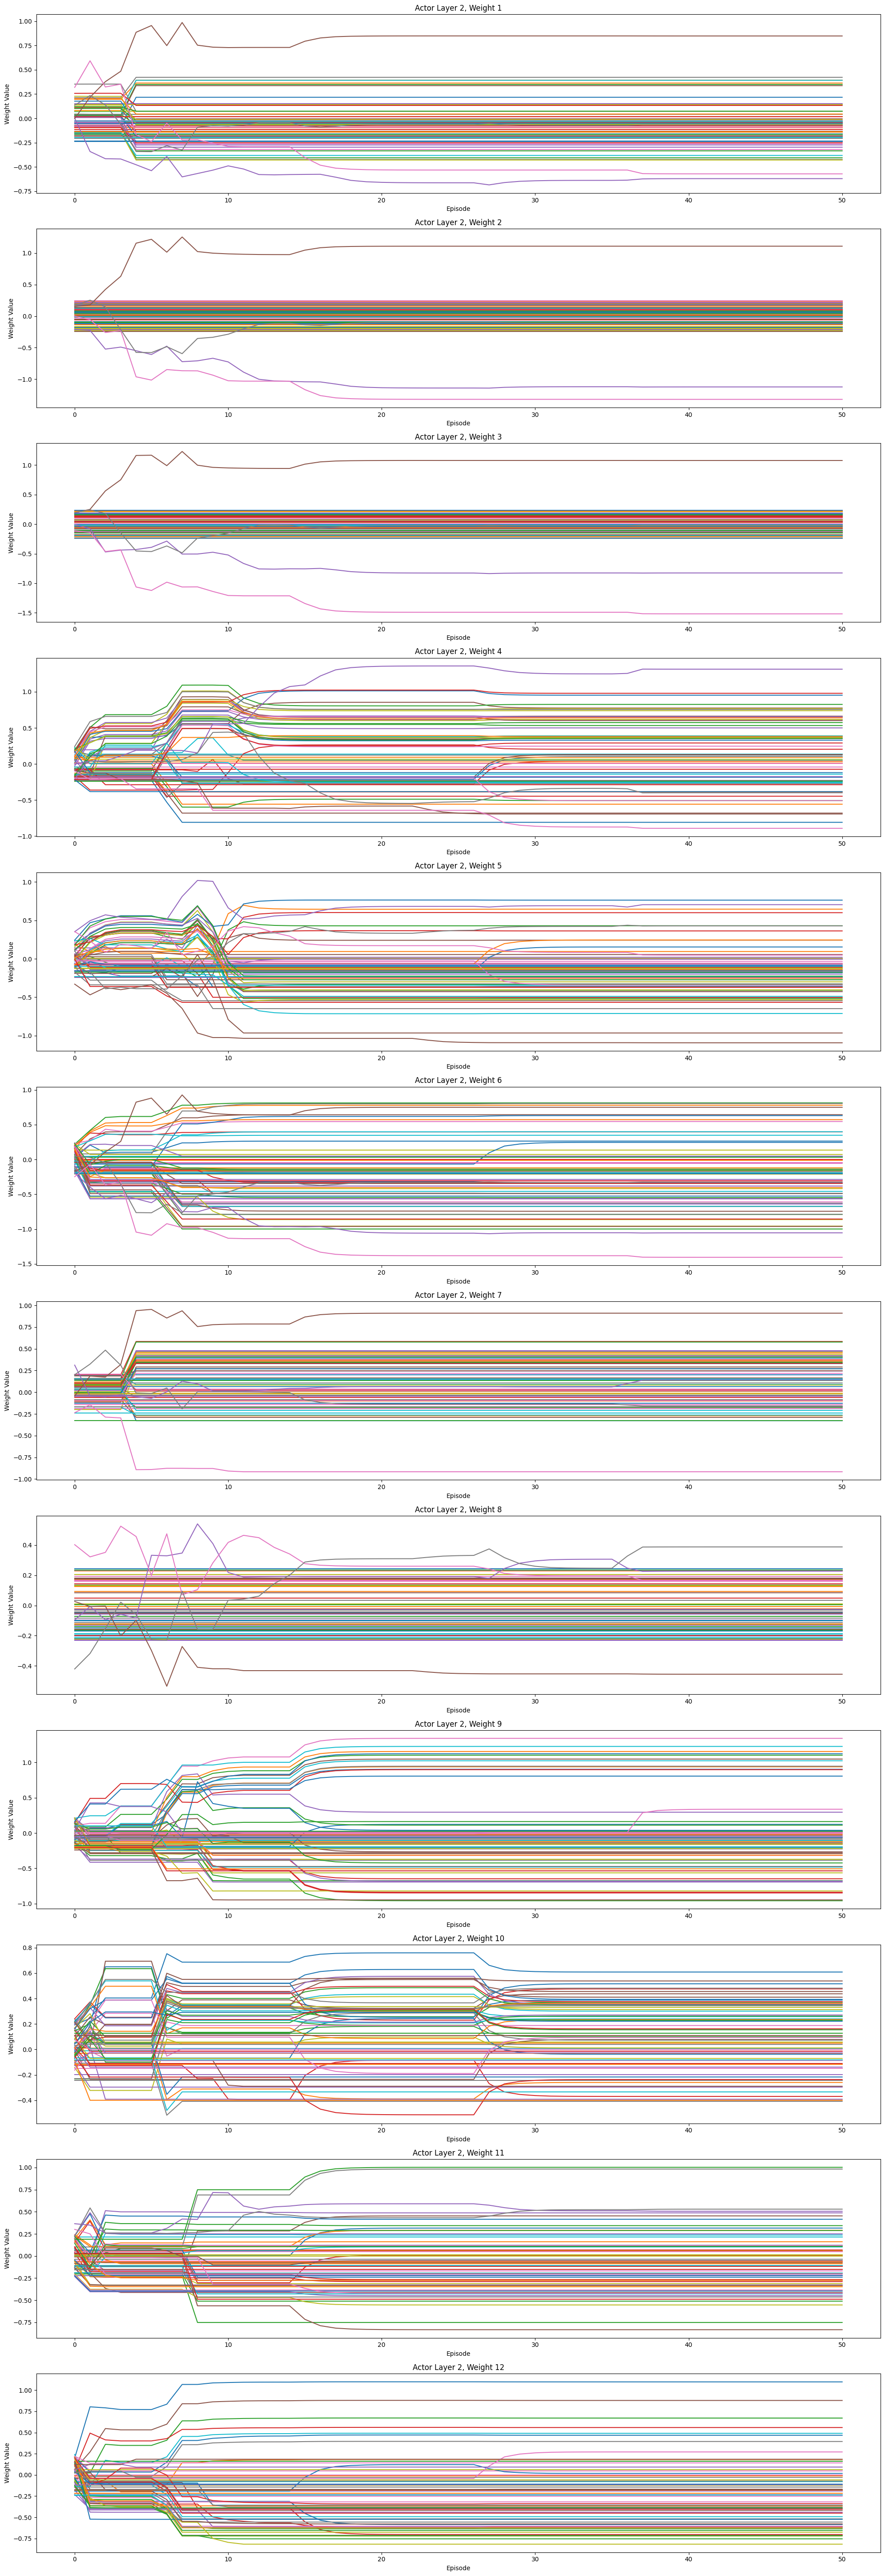

In [ ]:
# Import the required matplotlib module for plotting graphs
import matplotlib.pyplot as plt
import numpy as np

# Define a function to plot selected weights from neural network layers.
def plot_selective_weights(layer_weights, layer_name, num_weights=12):
    # Set up a figure with a specific size, in this case, quite large to accommodate many subplots.
    plt.figure(figsize=(20, 58))

    # Iterate through each layer in layer_weights. layer_index is the index of the layer,
    # and weights is the list of weights for that layer.
    for layer_index, weights in enumerate(layer_weights):
        # Convert the list of weights to a numpy array for easier slicing and select
        # the first 'num_weights' weights for plotting.
        selected_weights = np.array(weights)[:, :num_weights]

        # Create a subplot for each of the selected weights.
        for i in range(num_weights):
            # (num_weights, 1) denotes the grid size of the subplots, and i+1 is the index of the current subplot.
            plt.subplot(num_weights, 1, i+1)
            # Plot the weight values across episodes. The y-axis shows the weight values, and
            # the x-axis corresponds to the episode number.
            plt.plot(selected_weights[:, i])
            # Add a title to each subplot indicating which layer and weight it represents.
            plt.title(f'{layer_name} Layer {layer_index+1}, Weight {i+1}')
            # Label the x-axis as 'Episode' and the y-axis as 'Weight Value' for clarity.
            plt.xlabel('Episode')
            plt.ylabel('Weight Value')

    # Adjust the layout of the subplots to ensure there's no overlap and everything is neatly organized.
    plt.tight_layout()
    # Render the plot to the screen.
    plt.show()

# Example usage of the function. This would plot the first 12 weights of each layer of the 'actor_layer_weights' array,
# labeling the plots as belonging to the "Actor" network.
plot_selective_weights(actor_layer_weights, "Actor")


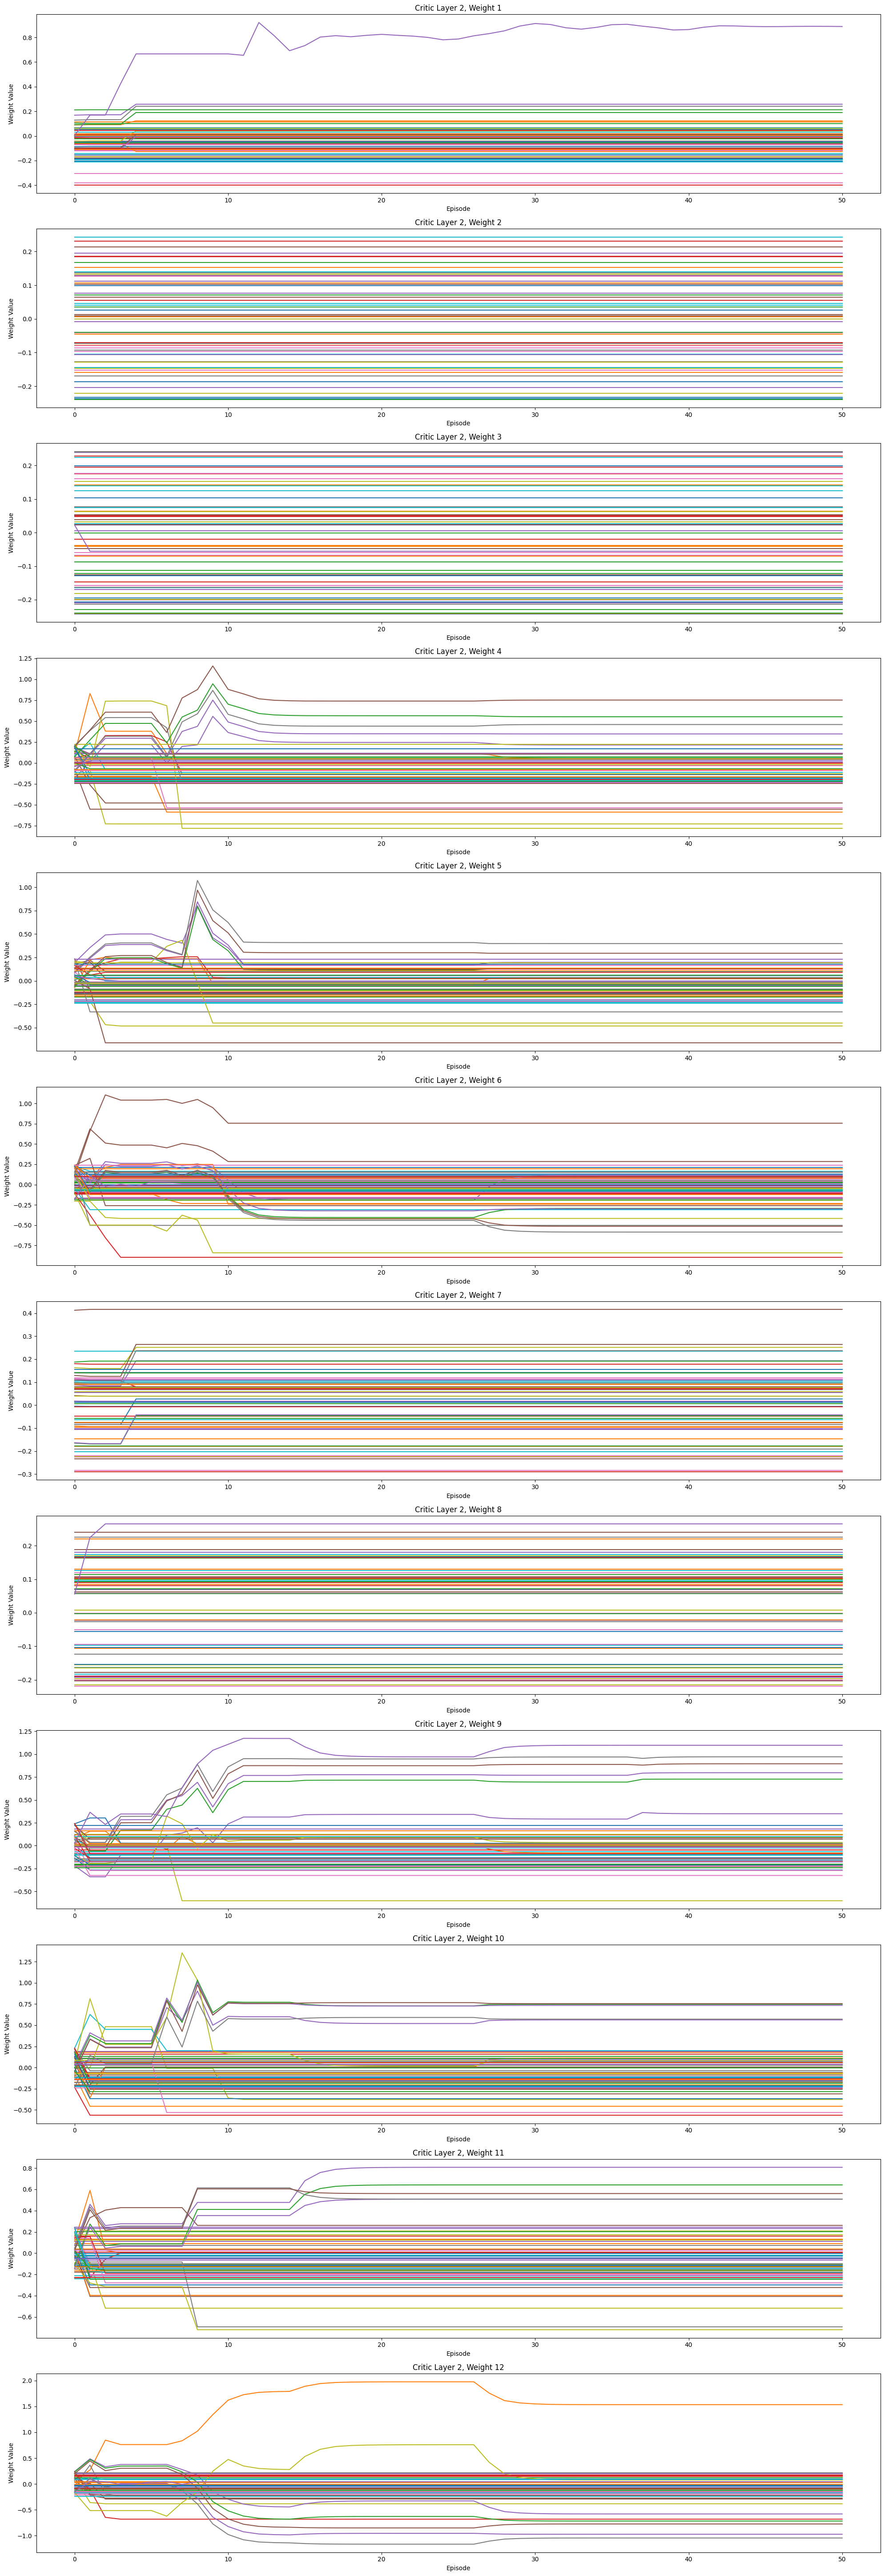

In [ ]:
plot_selective_weights(critic_layer_weights, "Critic")

In [ ]:
# Testing the learned policy
state = START
path = [state]

while state != GOAL:
    state_flat = np.zeros(NUM_STATES)
    state_flat[state_to_index(state)] = 1
    state_tensor = tf.convert_to_tensor([state_flat], dtype=tf.float32)
    action_probs = actor(state_tensor)
    action_index = tf.argmax(action_probs[0]).numpy()
    action = ACTIONS[action_index]
    next_state, _, _ = step(state, action)
    path.append(next_state)
    state = next_state

print("Learned Policy:")
for row in range(GRID_SIZE[0]):
    for col in range(GRID_SIZE[1]):
        state = (row, col)
        state_flat = np.zeros(NUM_STATES)
        state_flat[state_to_index(state)] = 1
        state_tensor = tf.convert_to_tensor([state_flat], dtype=tf.float32)
        action_probs = actor(state_tensor)
        action_index = tf.argmax(action_probs[0]).numpy()
        action = ACTIONS[action_index]
        print(f"State: {state}, Best Action: {action}")

print("\nOptimal Path:")
for state in path:
    print(state)

Learned Policy:
State: (0, 0), Best Action: RIGHT
State: (0, 1), Best Action: RIGHT
State: (0, 2), Best Action: RIGHT
State: (0, 3), Best Action: UP
State: (0, 4), Best Action: RIGHT
State: (0, 5), Best Action: DOWN
State: (1, 0), Best Action: UP
State: (1, 1), Best Action: RIGHT
State: (1, 2), Best Action: DOWN
State: (1, 3), Best Action: RIGHT
State: (1, 4), Best Action: RIGHT
State: (1, 5), Best Action: DOWN
State: (2, 0), Best Action: RIGHT
State: (2, 1), Best Action: RIGHT
State: (2, 2), Best Action: UP
State: (2, 3), Best Action: RIGHT
State: (2, 4), Best Action: RIGHT
State: (2, 5), Best Action: DOWN
State: (3, 0), Best Action: UP
State: (3, 1), Best Action: RIGHT
State: (3, 2), Best Action: UP
State: (3, 3), Best Action: RIGHT
State: (3, 4), Best Action: RIGHT
State: (3, 5), Best Action: RIGHT
State: (4, 0), Best Action: RIGHT
State: (4, 1), Best Action: RIGHT
State: (4, 2), Best Action: UP
State: (4, 3), Best Action: RIGHT
State: (4, 4), Best Action: RIGHT
State: (4, 5), Best 